In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Dec 18 05:11:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.3 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images.

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Automated Mask Generation

To run automatic mask generation, we are providing SAM model to the `SamAutomaticMaskGenerator` class. By setting the path below to the SAM checkpoint, running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "/content/0111.JPEG"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

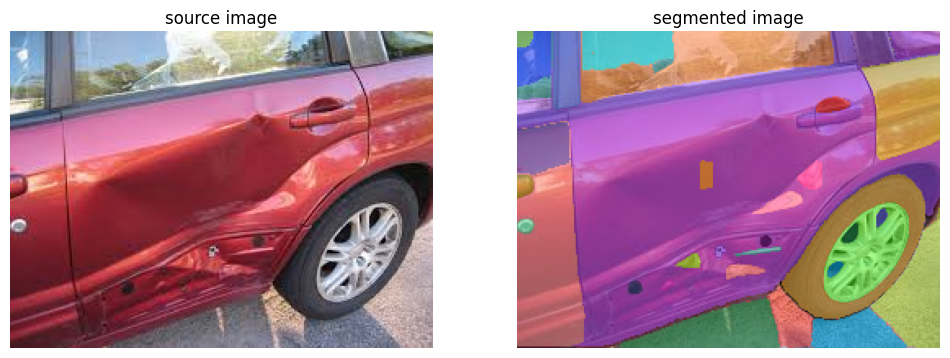

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

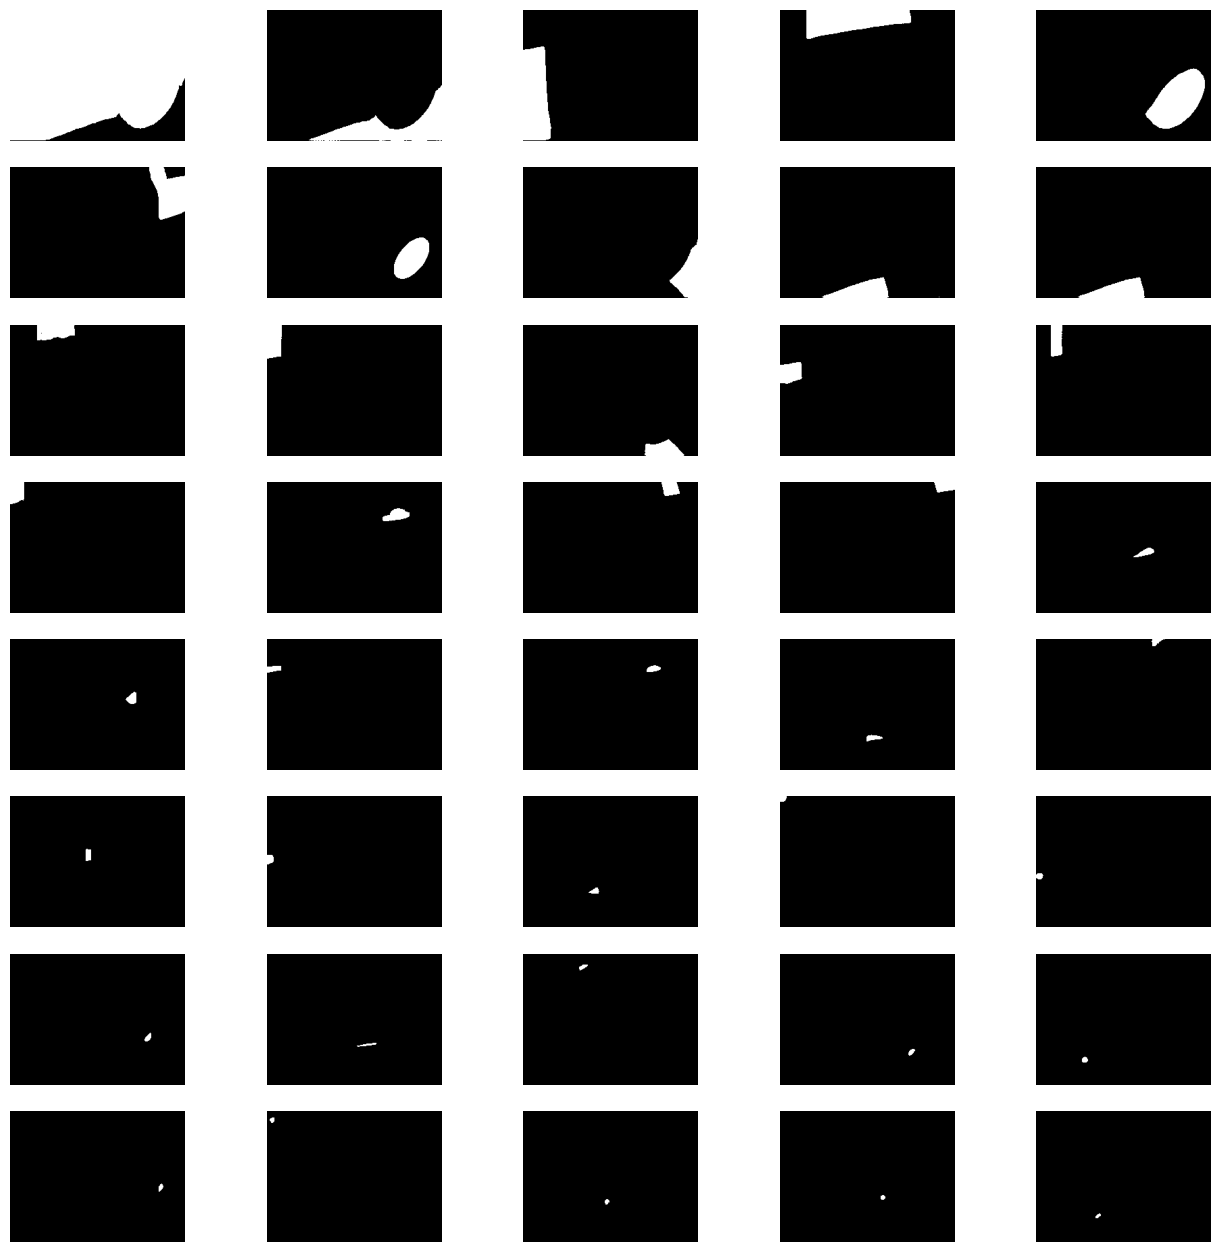

In [ ]:
import math

masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

# Calculate the number of columns, ensuring it's at least 1
ncols = max(1, math.ceil(len(masks) / 8))  # Use math.ceil to round up

sv.plot_images_grid(
    images=masks,
    grid_size=(8, ncols),  # Update grid_size with calculated ncols
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:

import os

IMAGE_NAME = "/content/0111.JPEG"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 42, 'y': 61, 'width': 164, 'height': 98, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

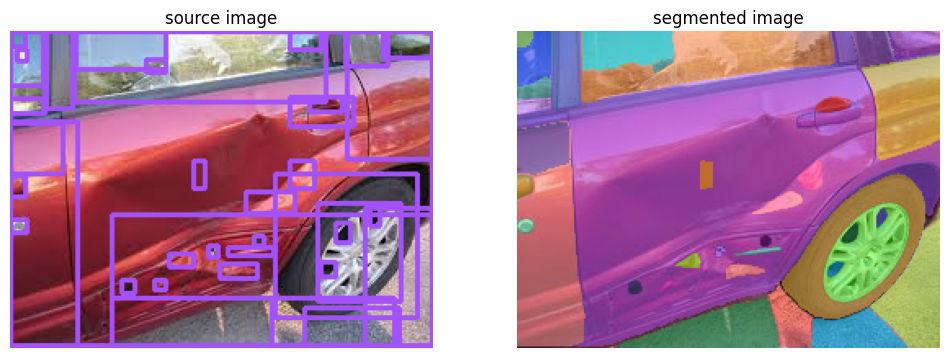

True

In [ ]:
import cv2  # Ensure you import OpenCV
import supervision as sv
import numpy as np

# Initialize the BoxAnnotator
box_annotator = sv.BoxAnnotator()

# Create detections with dummy class_id for box_annotator
# Convert class_id to integers using astype(int)
detections_with_class_id = sv.Detections(
    xyxy=detections.xyxy,
    mask=detections.mask,
    class_id=np.zeros(len(detections)).astype(int)  # Add dummy class_id as integers
)

# Annotate the image with boxes and masks
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections_with_class_id)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Plot the images in a grid
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


# Save the segmented image
cv2.imwrite('segmented_image.jpg', segmented_image)
#cv2.imwrite('source_image.jpg', source_image)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Enter the full path of the segmented image: /content/segmented_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


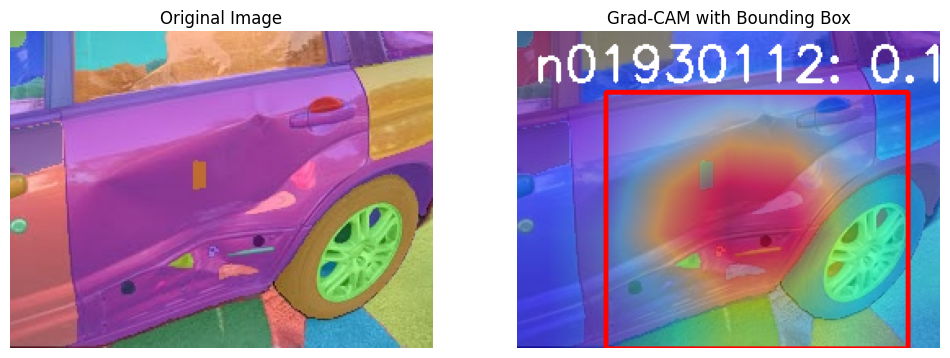

In [ ]:
import numpy as np
import cv2
import os
from keras.applications import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import decode_predictions
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Function to apply Grad-CAM
def grad_cam(model, img_array, class_index):
    last_conv_layer = model.get_layer('conv5_block3_out')
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[..., i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Function to display the image with Grad-CAM and bounding box
def display_grad_cam_with_bbox(img_path, heatmap, class_name, confidence, threshold=0.3):
    img = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
    img = np.array(img)

    # Resize the heatmap to match the original image dimensions
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Ensure both images have the same dimensions and channels
    if len(img.shape) == 2 or img.shape[2] != 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    # Threshold and find contours for high activation areas
    _, thresh = cv2.threshold(heatmap_resized, threshold * 255, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Add label with class name and confidence
    label = f"{class_name}: {confidence:.2f}"
    cv2.putText(superimposed_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Convert image to RGB for visualization
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Plot the original image and Grad-CAM overlay side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM with Bounding Box")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Main code
image_path = input("Enter the full path of the segmented image: ").strip()

# Preprocess the input image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Generate predictions
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=1)[0]
class_name, description, confidence = decoded_predictions[0]
# Generate Grad-CAM heatmap
class_index = np.argmax(predictions)
heatmap = grad_cam(model, img_array, class_index)

# Visualize the Grad-CAM overlay and bounding box
display_grad_cam_with_bbox(image_path, heatmap, class_name, confidence, threshold=0.3)


Enter the full path of the segmented image: /content/segmented_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


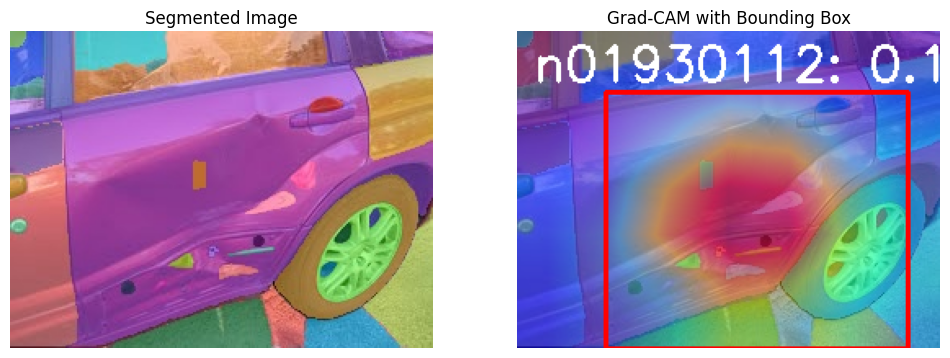

In [ ]:
import numpy as np
import cv2
import os
from keras.applications import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import decode_predictions
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Function to apply Grad-CAM
def grad_cam(model, img_array, class_index):
    last_conv_layer = model.get_layer('conv5_block3_out')
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[..., i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Function to display the image with Grad-CAM and bounding box
def display_grad_cam_with_bbox(img_path, heatmap, class_name, confidence, threshold=0.3):
    img = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
    img = np.array(img)

    # Resize the heatmap to match the original image dimensions
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Ensure both images have the same dimensions and channels
    if len(img.shape) == 2 or img.shape[2] != 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    # Threshold and find contours for high activation areas
    _, thresh = cv2.threshold(heatmap_resized, threshold * 255, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Add label with class name and confidence
    label = f"{class_name}: {confidence:.2f}"
    cv2.putText(superimposed_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Convert image to RGB for visualization
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Plot the original image and Grad-CAM overlay side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Segmented Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM with Bounding Box")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Main code
image_path = input("Enter the full path of the segmented image: ").strip()

# Preprocess the input image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Generate predictions
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=1)[0]
class_name, _, confidence = decoded_predictions[0]

# Generate Grad-CAM heatmap
class_index = np.argmax(predictions)
heatmap = grad_cam(model, img_array, class_index)

# Visualize the Grad-CAM overlay and bounding box
display_grad_cam_with_bbox(image_path, heatmap, class_name, confidence, threshold=0.3)


### Interaction with segmentation results

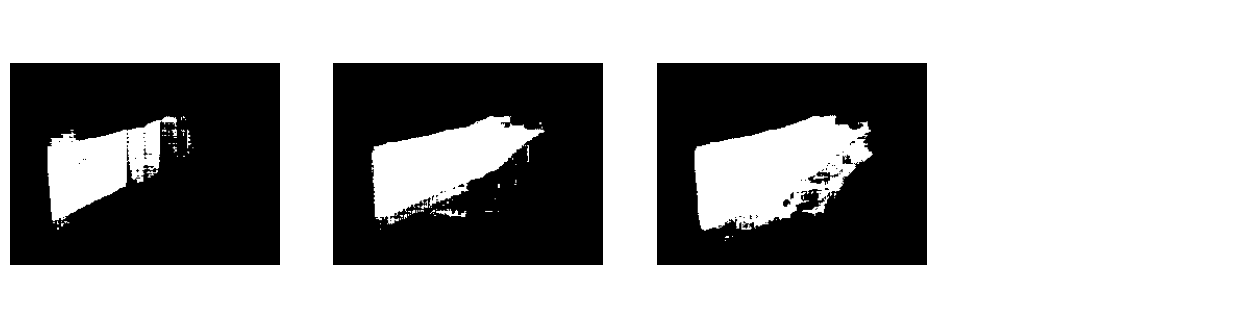

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

Enter the full path of the segmented image: /content/segmented_image.jpg
Enter the full path of the non-segmented image: /content/0111.JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Displaying results for the segmented image...


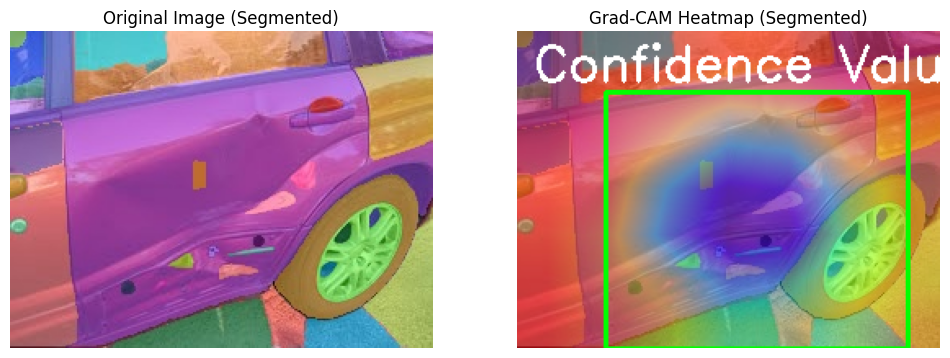

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Displaying results for the non-segmented image...


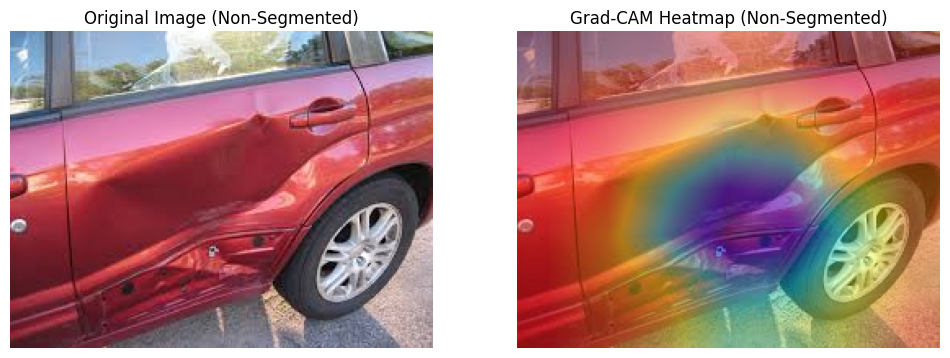

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import decode_predictions
import tensorflow as tf
from PIL import Image

# Function to apply Grad-CAM
def grad_cam(model, img_array, class_index):
    last_conv_layer = model.get_layer('conv5_block3_out')
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[..., i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Function to display Grad-CAM results

def display_grad_cam(image_path, heatmap, title_suffix, add_bbox=False, threshold=0.3, label=None):
    img = Image.open(image_path).convert('RGB')
    img = np.array(img)

    # Resize and superimpose the heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 2 else img
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

    if add_bbox:
        # Add bounding box based on the heatmap threshold
        _, binary_map = cv2.threshold(np.uint8(255 * heatmap_resized), int(threshold * 255), 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Add label if provided
    if label:
        cv2.putText(superimposed_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image ({title_suffix})")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap ({title_suffix})")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Paths to the segmented and non-segmented images
segmented_path = input("Enter the full path of the segmented image: ").strip()
non_segmented_path = input("Enter the full path of the non-segmented image: ").strip()

# Process Segmented Image
# Process Segmented Image
segmented_img = image.load_img(segmented_path, target_size=(224, 224))
segmented_array = np.expand_dims(image.img_to_array(segmented_img) / 255.0, axis=0)
segmented_pred = model.predict(segmented_array)
segmented_class_index = np.argmax(segmented_pred)
segmented_label = f"Confidence Value: {segmented_pred[0][segmented_class_index]:.2f}"
segmented_heatmap = grad_cam(model, segmented_array, segmented_class_index)



# Display Grad-CAM for segmented image
print("Displaying results for the segmented image...")
display_grad_cam(segmented_path, segmented_heatmap, "Segmented", add_bbox=True, threshold=0.3, label=segmented_label)

# Process Non-Segmented Image
non_segmented_img = image.load_img(non_segmented_path, target_size=(224, 224))
non_segmented_array = np.expand_dims(image.img_to_array(non_segmented_img) / 255.0, axis=0)
non_segmented_pred = model.predict(non_segmented_array)
non_segmented_class_index = np.argmax(non_segmented_pred)
non_segmented_heatmap = grad_cam(model, non_segmented_array, non_segmented_class_index)

# Display Grad-CAM for non-segmented image
print("Displaying results for the non-segmented image...")
display_grad_cam(non_segmented_path, non_segmented_heatmap, "Non-Segmented",add_bbox=False)


Enter the full path of the segmented image: /content/segmented_image.jpg
Enter the full path of the non-segmented image: /content/0111.JPEG
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Displaying results for the segmented image...


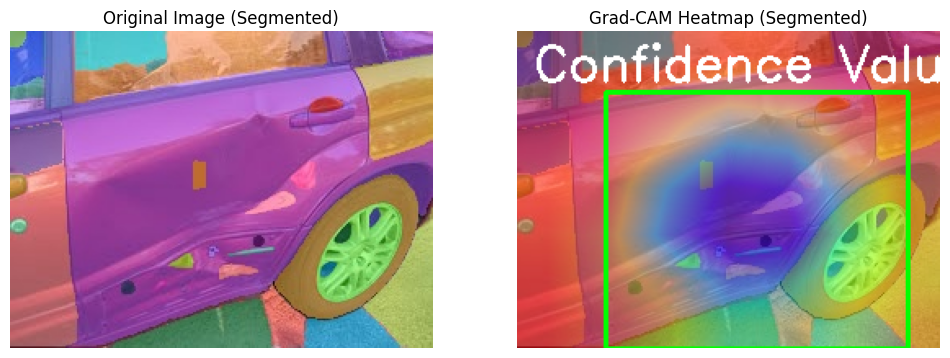

Extracting bounding box dimensions from Grad-CAM heatmap (for segmented image)...


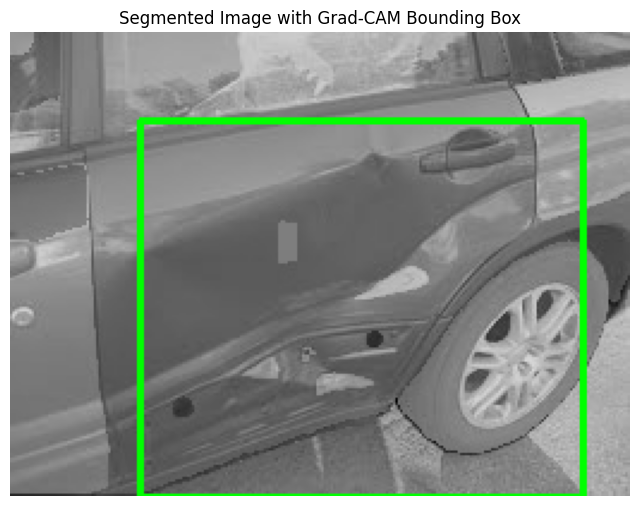

Grad-CAM Bounding Box Dimensions for Segmented Image: x_min=54, y_min=37, x_max=239, y_max=194


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import decode_predictions
import tensorflow as tf
from PIL import Image


# Function to apply Grad-CAM
def grad_cam(model, img_array, class_index):
    last_conv_layer = model.get_layer('conv5_block3_out')
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[..., i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# Function to display Grad-CAM results
def display_grad_cam(image_path, heatmap, title_suffix, add_bbox=False, threshold=0.3, label=None):
    img = Image.open(image_path).convert('RGB')
    img = np.array(img)

    # Resize and superimpose the heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 2 else img
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

    if add_bbox:
        # Add bounding box based on the heatmap threshold
        _, binary_map = cv2.threshold(np.uint8(255 * heatmap_resized), int(threshold * 255), 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Convert to [x_min, y_min, x_max, y_max] format
            x_min = x
            y_min = y
            x_max = x + w
            y_max = y + h

            # Draw bounding box
            cv2.rectangle(superimposed_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Add label if provided
    if label:
        cv2.putText(superimposed_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image ({title_suffix})")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap ({title_suffix})")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


# Function to extract bounding box dimensions from Grad-CAM heatmap (for segmented image)
def get_bbox_from_grad_cam_for_segmented_image(heatmap, segmented_image_path, threshold=0.3):
    """
    Extract the bounding box dimensions (x, y, width, height) from the Grad-CAM heatmap
    on the segmented image.

    Args:
        heatmap (numpy.ndarray): Grad-CAM heatmap (resized to match the segmented image).
        segmented_image_path (str): Path to the segmented image (for visualization purposes).
        threshold (float): Threshold for identifying regions of interest in the heatmap.

    Returns:
        tuple: (x_min, y_min, x_max, y_max) of the bounding box, or None if no region is found.
    """
    # Load the segmented image (which should be in grayscale)
    segmented_img = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
    segmented_img_rgb = cv2.cvtColor(segmented_img, cv2.COLOR_GRAY2BGR)

    # Resize the heatmap to match the segmented image size
    heatmap_resized = cv2.resize(heatmap, (segmented_img.shape[1], segmented_img.shape[0]))

    # Apply binary thresholding to the heatmap
    _, binary_map = cv2.threshold(np.uint8(255 * heatmap_resized), int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Find contours in the binary heatmap
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour (assuming it's the most relevant region)
        largest_contour = max(contours, key=cv2.contourArea)

        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Convert to [x_min, y_min, x_max, y_max] format
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h

        # Draw bounding box on the segmented image
        cv2.rectangle(segmented_img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Display the segmented image with bounding box
        plt.figure(figsize=(8, 8))
        plt.title("Segmented Image with Grad-CAM Bounding Box")
        plt.imshow(cv2.cvtColor(segmented_img_rgb, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        # Return bounding box dimensions in [x_min, y_min, x_max, y_max] format
        return x_min, y_min, x_max, y_max
    else:
        print("No significant region detected in the heatmap.")
        return None


# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Paths to the segmented and non-segmented images
segmented_path = input("Enter the full path of the segmented image: ").strip()
non_segmented_path = input("Enter the full path of the non-segmented image: ").strip()

# Process Segmented Image
segmented_img = image.load_img(segmented_path, target_size=(224, 224))
segmented_array = np.expand_dims(image.img_to_array(segmented_img) / 255.0, axis=0)
segmented_pred = model.predict(segmented_array)
segmented_class_index = np.argmax(segmented_pred)
segmented_label = f"Confidence Value: {segmented_pred[0][segmented_class_index]:.2f}"
segmented_heatmap = grad_cam(model, segmented_array, segmented_class_index)

# Display Grad-CAM for segmented image
print("Displaying results for the segmented image...")
display_grad_cam(segmented_path, segmented_heatmap, "Segmented", add_bbox=True, threshold=0.3, label=segmented_label)

# Extract bounding box dimensions from Grad-CAM heatmap for the segmented image
print("Extracting bounding box dimensions from Grad-CAM heatmap (for segmented image)...")
bounding_box = get_bbox_from_grad_cam_for_segmented_image(segmented_heatmap, segmented_path, threshold=0.3)
if bounding_box:
    x_min, y_min, x_max, y_max = bounding_box
    print(f"Grad-CAM Bounding Box Dimensions for Segmented Image: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")
else:
    print("No bounding box could be extracted from the Grad-CAM heatmap.")


# RESNET-50

In [ ]:
!pip install imgaug

In [ ]:
# import basic libraries
import os
from os import listdir
import sys
import json
import datetime

# import advance libraries
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug



# import matplotlib library
import matplotlib.pyplot as plt

# import numpy libraries
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


In [ ]:
#add_class={}
add_image=[]

In [ ]:
# load_dataset function is used to load the train and test dataset
def load_dataset(dataset_dir, is_train=True):
    global add_class, add_image
    # we add a class that we need to classify in our case it is Damage
    #add_class["dataset_1"]= "Damage"

    # we concatenate the dataset_dir with /images and /annots
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'

    # is_train will be true if we our training our model and false when we are testing the model
    print('images_dir',images_dir)
    for filename in listdir(images_dir):

        # extract image id
        image_id = filename[:-4] # used to skip last 4 chars which is '.jpg' (class_id.jpg)

        # if is_train is True skip all images with id greater than and equal to 420
        # roughly 80% of dataset for training
        if is_train and int(image_id) >= 420 :
            continue

        # if is_train is not True skip all images with id less than 420
        if not is_train and int(image_id) < 420:
            continue

        # declaring image path and annotations path
        img_path = images_dir + filename
        ann_path = annotations_dir + image_id + '.xml'

        # using add_image function we pass image_id, image_path and ann_path so that the current
        # image is added to the dataset for training or testing
        print(image_id,img_path,ann_path)
        add_image.append(('dataset', image_id, img_path, ann_path))

In [ ]:
# function used to extract bouding boxes from annotated files
def extract_boxes(filename):

    # you can see how the images are annotated we extracrt the width, height and bndbox values

    # <annotation>
    # <size>

    #       <width>640</width>

    #       <height>360</height>

    #       <depth>3</depth>

    # </size>


    # <object>

    #          <name>damage</name>

    #          <pose>Unspecified</pose>

    #          <truncated>0</truncated>

    #          <difficult>0</difficult>


    #          <bndbox>

    #                 <xmin>315</xmin>

    #                 <ymin>160</ymin>

    #                 <xmax>381</xmax>

    #                 <ymax>199</ymax>

    #          </bndbox>

    # </object>
    # </annotation>

    # used to parse the .xml files
    tree = ElementTree.parse(filename)

    # to get the root of the xml file
    root = tree.getroot()

    # we will append all x, y coordinated in boxes
    # for all instances of an onject
    boxes = list()

    # we find all attributes with name bndbox
    # bndbox will exist for each ground truth in image
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)

    # extract width and height of the image
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)

    # return boxes-> list, width-> int and height-> int
    return boxes, width, height

In [ ]:
# this function calls on the extract_boxes method and is used to load a mask for each instance in an image
# returns a boolean mask with following dimensions width * height * instances
def load_mask(image_id):

    # info points to the current image_id
    info = image_info[image_id]

    # we get the annotation path of image_id which is dataset_dir/annots/image_id.xml
    path = info['annotation']

    # we call the extract_boxes method(above) to get bndbox from .xml file
    boxes, w, h = extract_boxes(path)

    # we create len(boxes) number of masks of height 'h' and width 'w'
    masks = zeros([h, w, len(boxes)], dtype='uint8')

    # we append the class_id 1 for Damage in our case to the variable
    class_ids = list()

    # we loop over all boxes and generate masks (bndbox mask) and class id for each instance
    # masks will have rectange shape as we have used bndboxes for annotations
    # for example:  if 2.jpg have three objects we will have following masks and class_ids
    # 000000000 000000000 000001110
    # 000011100 011100000 000001110
    # 000011100 011100000 000001110
    # 000000000 011100000 000000000
    #    1         1          1    <- class_ids
    for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(class_names.index('Damage'))

    # return masks and class_ids as array
    return masks, asarray(class_ids, dtype='int32')

In [ ]:
# this functions takes the image_id and returns the path of the image
def image_reference(image_id):
    info = image_info[image_id]
    return info['path']

In [ ]:
load_dataset('/content/drive/MyDrive/Dataset stages/Stage 1/stage-1', is_train=True)

images_dir /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/
161 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/161.jpg /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/161.xml
120 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/120.jpg /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/120.xml
171 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/171.jpg /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/171.xml
180 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/180.jpg /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/180.xml
109 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/109.jpg /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/109.xml
121 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/121.jpg /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/121.xml
139 /content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/139.jpg /c

In [ ]:
for i in add_image:
    print(i)

('dataset', '161', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/161.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/161.xml')
('dataset', '120', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/120.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/120.xml')
('dataset', '171', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/171.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/171.xml')
('dataset', '180', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/180.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/180.xml')
('dataset', '109', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/109.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/109.xml')
('dataset', '121', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/121.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/121.xml')
('dataset', '139', '/c

In [ ]:
load_dataset('/content/drive/MyDrive/Dataset stages/Stage 2/stage-2', is_train=True)

images_dir /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/
10 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/10.jpg /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/10.xml
100 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/100.jpg /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/100.xml
1 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/1.jpg /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/1.xml
101 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/101.jpg /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/101.xml
120 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/120.jpg /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/120.xml
110 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/110.jpg /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/110.xml
116 /content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/116.jpg /content/dr

In [ ]:
for i in add_image:
    print(i)
    boxes, width, height=extract_boxes(i[3])
    print(boxes, width, height)

('dataset', '161', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/161.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/161.xml')
[[335, 388, 465, 577], [121, 331, 318, 587], [5, 403, 117, 588]] 800 600
('dataset', '120', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/120.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/120.xml')
[[95, 82, 253, 214], [267, 114, 392, 261]] 800 600
('dataset', '171', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/171.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/171.xml')
[[268, 436, 291, 463], [311, 532, 353, 548]] 800 600
('dataset', '180', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/180.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/180.xml')
[[158, 218, 237, 292]] 640 480
('dataset', '109', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/109.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/st

In [ ]:
from PIL import Image

def crop_image(input_image_path, output_image_path, box):
    """
    Crops an image based on the specified box coordinates (left, upper, right, lower).

    :param input_image_path: Path to the input image.
    :param output_image_path: Path to save the cropped image.
    :param box: A tuple (left, upper, right, lower) defining the crop area.
    """
    try:
        # Open the image
        image = Image.open(input_image_path)

        # Crop the image using the box coordinates
        cropped_image = image.crop(box)

        # Save the cropped image
        cropped_image.save(output_image_path)

        print(f"Cropped image saved at {output_image_path}")

    except Exception as e:
        print(f"An error occurred: {e}")



In [ ]:
# Example usage
input_image_path = "/content/0111.JPEG"  # Path to your input image
output_image_path = "output_cropped.jpg"  # Path to save the cropped image

# Box coordinates (left, upper, right, lower)
box = (65, 60, 145, 160)  # Example crop region

crop_image(input_image_path, output_image_path, box)


Cropped image saved at output_cropped.jpg


In [ ]:
c=0
for i in add_image:
    print(i)
    boxes, width, height=extract_boxes(i[3])
    print(boxes, width, height)
    input_image_path = i[2]
    output_image_path = "/content/output_cropped"+str(c)+".jpg"  # Path to save the cropped image

#/content/drive/MyDrive/code/4/output/0.jpg


    crop_image(input_image_path, output_image_path, boxes[0])
    c=c+1

('dataset', '161', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/161.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/161.xml')
[[335, 388, 465, 577], [121, 331, 318, 587], [5, 403, 117, 588]] 800 600
Cropped image saved at /content/output_cropped0.jpg
('dataset', '120', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/120.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/120.xml')
[[95, 82, 253, 214], [267, 114, 392, 261]] 800 600
Cropped image saved at /content/output_cropped1.jpg
('dataset', '171', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/171.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/171.xml')
[[268, 436, 291, 463], [311, 532, 353, 548]] 800 600
Cropped image saved at /content/output_cropped2.jpg
('dataset', '180', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/180.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/180.xml')
[[158, 218, 237

In [ ]:
boxes =  extract_boxes("/content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/100.xml")
boxes

([[349, 404, 737, 610]], 1024, 768)

In [ ]:
image_info = [
    {
        'annotation': '/content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/100.xml',
        'path': '/content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/100.jpg'
    }
]

class_names = ['Original', 'Damage']  # Assuming 'Damage' is the class for your bounding boxes


(768, 1024, 3)


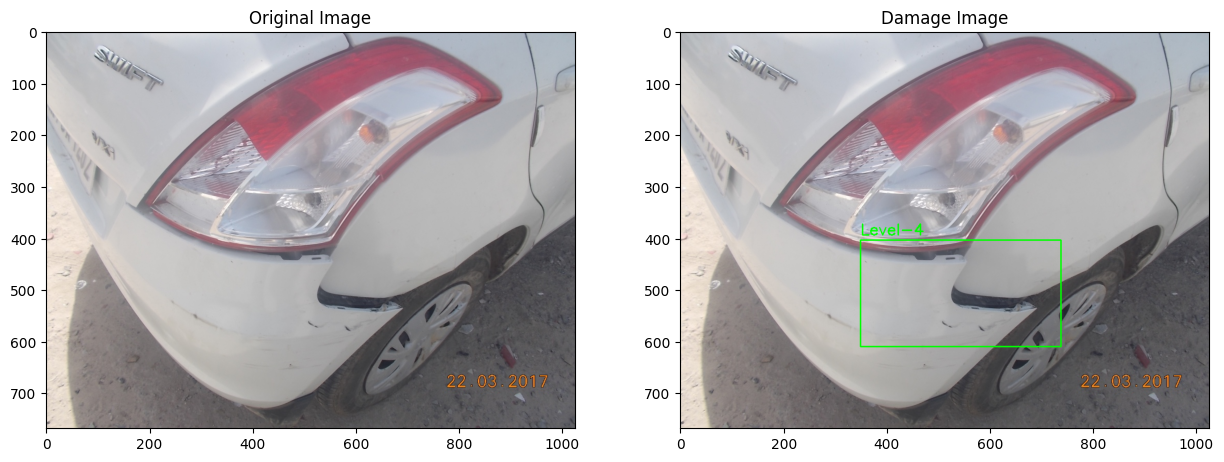

In [ ]:
# Function to read XML annotations
import xml.etree.ElementTree as ET
import skimage.io as io # Import the 'io' module from scikit-image
import matplotlib.pyplot as plt
import cv2 # Import the OpenCV library

def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []

    for boxes in root.iter('object'):
        filename = root.find('filename').text
        classname = boxes.find("name").text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        # Append filename, bounding box coordinates, and class name
        list_with_single_boxes = [filename, xmin, ymin, xmax, ymax, classname]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes

# Load an example image and its bounding boxes
boxes = read_content("/content/drive/MyDrive/Dataset stages/Stage 2/stage-2/annots/100.xml")
img = io.imread('/content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/100.jpg') # Use 'io' which is now defined

# Get image dimensions
height, width, _ = img.shape
print(img.shape)

# Plot the original image
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)

# Create a copy of the image for displaying bounding boxes
img_bbox = img.copy()

# Loop through the boxes and annotate the image
for i in range(len(boxes)):
    xmin = boxes[i][1]
    ymin = boxes[i][2]
    xmax = boxes[i][3]
    ymax = boxes[i][4]
    class_name = boxes[i][5]

    # Draw the bounding box
    cv2.rectangle(img_bbox, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Add the class name as a label
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox, class_name, (xmin, ymin - 10), font, 1, (0, 255, 0), 2)

# Plot the image with bounding boxes
plt.subplot(1, 2, 2)
plt.title('Damage Image')
plt.imshow(img_bbox)
plt.show()

In [ ]:
from PIL import Image, ImageDraw
input_image_path='/content/0111.JPEG'
# Create an image (white background)
image = Image.open(input_image_path)
draw = ImageDraw.Draw(image)

# Define the four coordinates (left, upper, right, lower)
left, upper, right, lower = 315, 160, 381, 199

# Draw lines connecting the four points
draw.line([(left, upper), (right, upper)], fill='black', width=2)  # Top edge
draw.line([(right, upper), (right, lower)], fill='black', width=2)  # Right edge
draw.line([(right, lower), (left, lower)], fill='black', width=2)  # Bottom edge
draw.line([(left, lower), (left, upper)], fill='black', width=2)  # Left edge

# Save or show the image
image.show()  # To display the image
image.save('rectangle_image.png')  # To save the image


In [ ]:
from PIL import Image, ImageDraw

input_image_path = '/content/drive/MyDrive/Dataset stages/Stage 2/stage-2/images/1.jpg'

# Load the image
image = Image.open(input_image_path)
draw = ImageDraw.Draw(image)

# Original coordinates (left, upper, right, lower)
left, upper, right, lower = 315, 160, 381, 199

# Amount to expand the bounding box by (in pixels)
expand_by = 150

# Calculate the new coordinates
left -= expand_by
upper -= expand_by
lower += expand_by

# Draw the expanded rectangle
draw.line([(left, upper), (right, upper)], fill='black', width=2)  # Top edge
draw.line([(right, upper), (right, lower)], fill='black', width=2)  # Right edge
draw.line([(right, lower), (left, lower)], fill='black', width=2)  # Bottom edge
draw.line([(left, lower), (left, upper)], fill='black', width=2)  # Left edge

# Save or show the image
image.show()  # To display the image
image.save('expanded_rectangle_image.png')  # To save the image



In [ ]:
c=0
for i in add_image:
    print(i)
    boxes, width, height=extract_boxes(i[3])
    print(boxes, width, height)
    input_image_path = i[2]
    output_image_path = "/content/output_cropped_"+str(c)+".jpg"  # Path to save the cropped image
#/content/drive/MyDrive/code/4/output/0.jpg
    crop_image(input_image_path, output_image_path, boxes[0])
    c=c+1

('dataset', '161', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/161.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/161.xml')
[[335, 388, 465, 577], [121, 331, 318, 587], [5, 403, 117, 588]] 800 600
Cropped image saved at /content/output_cropped_0.jpg
('dataset', '120', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/120.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/120.xml')
[[95, 82, 253, 214], [267, 114, 392, 261]] 800 600
Cropped image saved at /content/output_cropped_1.jpg
('dataset', '171', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/171.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/171.xml')
[[268, 436, 291, 463], [311, 532, 353, 548]] 800 600
Cropped image saved at /content/output_cropped_2.jpg
('dataset', '180', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/180.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/180.xml')
[[158, 218, 

In [ ]:
images = []
labels = []

In [ ]:
def preprocess_image(image, size=(150, 150)):
    # If the image is not RGB, convert it to RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')
    # Resize the image to the desired size
    image = image.resize(size)
    # Convert the image to a NumPy array
    return np.array(image)

In [ ]:
from PIL import Image
for i in add_image:
    print(i)
    boxes, width, height=extract_boxes(i[3])
    print(boxes, width, height)
    input_image_path = i[2]
    image = Image.open(input_image_path)
    processed_image = preprocess_image(image, size=(300, 300))
    images.append(processed_image)  # Add the processed image to the list
    labels.append(boxes[0])

('dataset', '161', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/161.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/161.xml')
[[335, 388, 465, 577], [121, 331, 318, 587], [5, 403, 117, 588]] 800 600
('dataset', '120', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/120.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/120.xml')
[[95, 82, 253, 214], [267, 114, 392, 261]] 800 600
('dataset', '171', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/171.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/171.xml')
[[268, 436, 291, 463], [311, 532, 353, 548]] 800 600
('dataset', '180', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/180.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/annots/180.xml')
[[158, 218, 237, 292]] 640 480
('dataset', '109', '/content/drive/MyDrive/Dataset stages/Stage 1/stage-1/images/109.jpg', '/content/drive/MyDrive/Dataset stages/Stage 1/st

In [ ]:
images

[array([[[179, 188, 197],
         [181, 190, 199],
         [182, 189, 199],
         ...,
         [ 97, 100,  88],
         [ 81,  84,  76],
         [125, 128, 119]],
 
        [[180, 189, 198],
         [181, 189, 199],
         [183, 190, 200],
         ...,
         [ 79,  83,  70],
         [101, 104,  94],
         [124, 127, 118]],
 
        [[181, 189, 198],
         [181, 188, 198],
         [182, 189, 199],
         ...,
         [ 68,  70,  57],
         [115, 117, 105],
         [123, 125, 114]],
 
        ...,
 
        [[172, 168, 165],
         [172, 168, 165],
         [172, 168, 165],
         ...,
         [177, 168, 158],
         [176, 167, 157],
         [177, 168, 158]],
 
        [[170, 166, 163],
         [172, 168, 165],
         [172, 168, 165],
         ...,
         [176, 168, 157],
         [175, 167, 156],
         [176, 168, 157]],
 
        [[168, 164, 161],
         [169, 165, 162],
         [171, 167, 164],
         ...,
         [175, 167, 156],
  

In [ ]:
labels

[[335, 388, 465, 577],
 [95, 82, 253, 214],
 [268, 436, 291, 463],
 [158, 218, 237, 292],
 [250, 382, 416, 513],
 [509, 208, 743, 318],
 [434, 170, 490, 221],
 [31, 211, 338, 435],
 [396, 73, 507, 194],
 [50, 450, 172, 540],
 [50, 216, 91, 270],
 [114, 44, 198, 129],
 [124, 90, 512, 292],
 [262, 315, 375, 363],
 [141, 117, 655, 461],
 [163, 118, 200, 163],
 [262, 485, 283, 557],
 [484, 248, 529, 393],
 [65, 197, 527, 421],
 [42, 36, 409, 392],
 [84, 121, 473, 440],
 [1, 344, 304, 471],
 [278, 66, 316, 104],
 [98, 154, 466, 426],
 [15, 329, 573, 443],
 [128, 139, 505, 289],
 [3, 393, 37, 436],
 [486, 343, 508, 372],
 [330, 310, 418, 443],
 [223, 221, 285, 261],
 [262, 128, 376, 216],
 [214, 595, 329, 793],
 [205, 248, 236, 290],
 [173, 133, 433, 513],
 [230, 201, 281, 260],
 [440, 384, 492, 424],
 [302, 241, 326, 263],
 [1311, 510, 1411, 710],
 [4, 7, 595, 420],
 [305, 278, 372, 314],
 [261, 366, 350, 405],
 [93, 205, 198, 335],
 [422, 326, 601, 596],
 [645, 297, 717, 378],
 [315, 160, 

In [ ]:

labels=np.array(labels)

In [ ]:
labels

array([[335, 388, 465, 577],
       [ 95,  82, 253, 214],
       [268, 436, 291, 463],
       ...,
       [ 72, 100, 215, 182],
       [283, 125, 445, 258],
       [  3,  65, 239, 161]])

In [ ]:
images=np.array(images)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image


In [ ]:

# Normalize the images and labels
images = images / 255.0  # Normalizing the image pixel values to 0-1
#labels = labels / [150, 150, 150, 150]  # Normalize bounding box coordinates based on image size

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[[[0.2       , 0.19215686, 0.23529412],
         [0.20784314, 0.20784314, 0.24313725],
         [0.21960784, 0.22352941, 0.24705882],
         ...,
         [0.58431373, 0.56470588, 0.54117647],
         [0.58823529, 0.56862745, 0.54509804],
         [0.58823529, 0.56862745, 0.5372549 ]],

        [[0.18431373, 0.18431373, 0.22352941],
         [0.20392157, 0.20392157, 0.23921569],
         [0.20784314, 0.20784314, 0.23921569],
         ...,
         [0.58431373, 0.56470588, 0.54117647],
         [0.58823529, 0.56862745, 0.54509804],
         [0.59607843, 0.57254902, 0.54901961]],

        [[0.16862745, 0.17254902, 0.20784314],
         [0.18431373, 0.18823529, 0.21960784],
         [0.19607843, 0.20392157, 0.23137255],
         ...,
         [0.58823529, 0.56078431, 0.5372549 ],
         [0.59607843, 0.56862745, 0.54509804],
         [0.58431373, 0.55686275, 0.53333333]],

        ...,

        [[0.48235294, 0.45490196, 0.43529412],
         [0.50588235, 0.4745098 , 0.46666667]

In [ ]:
X_test

array([[[[0.50588235, 0.49411765, 0.48627451],
         [0.50980392, 0.49411765, 0.49019608],
         [0.50980392, 0.49411765, 0.48235294],
         ...,
         [0.94901961, 0.94901961, 0.94901961],
         [0.94901961, 0.94901961, 0.94901961],
         [0.94901961, 0.94901961, 0.94901961]],

        [[0.49803922, 0.49019608, 0.48235294],
         [0.50588235, 0.49019608, 0.48235294],
         [0.50980392, 0.49411765, 0.48235294],
         ...,
         [0.95294118, 0.95294118, 0.95294118],
         [0.94901961, 0.94901961, 0.94901961],
         [0.94901961, 0.94901961, 0.94901961]],

        [[0.49803922, 0.49019608, 0.48627451],
         [0.50196078, 0.48627451, 0.47843137],
         [0.50980392, 0.49411765, 0.48235294],
         ...,
         [0.95294118, 0.95294118, 0.95294118],
         [0.95294118, 0.95294118, 0.95294118],
         [0.94901961, 0.94901961, 0.94901961]],

        ...,

        [[0.11372549, 0.12156863, 0.1254902 ],
         [0.11372549, 0.11764706, 0.11764706]

In [ ]:
y_train

array([[484, 248, 529, 393],
       [437, 420, 471, 451],
       [350, 298, 366, 361],
       ...,
       [373, 495, 403, 547],
       [397, 189, 595, 446],
       [336, 274, 381, 305]])

In [ ]:
y_test

array([[ 438,  186,  515,  246],
       [ 178,  401,  246,  454],
       [ 382,  368,  603,  525],
       [  64,  136,  174,  218],
       [   1,   44,  459,  440],
       [ 262,  128,  376,  216],
       [ 383,  308,  558,  531],
       [ 251,   80,  385,  173],
       [ 351,  358,  665,  573],
       [ 936,  826, 1011,  878],
       [ 130,  137,  538,  322],
       [   0,  182,  267,  432],
       [ 235,  383,  320,  440],
       [ 440,  217, 1141,  949],
       [ 349,  404,  737,  610],
       [ 377,  541,  499,  589],
       [ 424,  348,  520,  557],
       [ 609,  367,  825,  409],
       [ 443,  309, 1024,  632],
       [ 123,    6,  425,  359],
       [ 292,  326,  464,  522],
       [  50,  450,  172,  540],
       [ 173,   30,  615,  485],
       [ 481,  309,  787,  542],
       [ 250,  200,  515,  400],
       [ 249,  236,  785,  690],
       [ 135,  322,  210,  379],
       [ 350,  237, 1589,  979],
       [  56,  166,  635,  448],
       [ 305,  278,  372,  314],
       [ 4

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(356, 90, 356, 90)

In [ ]:
# Define the CNN model for bounding box regression
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='sigmoid')  # Output 4 values: left, upper, right, lower
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

In [ ]:
model = create_model()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy for sample data creation

# Create sample data for demonstration if X and y are not available
# Replace with your actual data loading process
X = np.random.rand(1000, 300, 300, 3) # Example feature data of shape (samples, height, width, channels)
y = np.random.rand(1000, 4)  # Example target data with 4 values per sample

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # 30% for validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Split the remaining 30% equally for validation and test


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# Save the model


model.save('car_dent_detection_model.h5')


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 854ms/step - loss: 0.1533 - val_loss: 0.0769
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0856 - val_loss: 0.0766
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0841 - val_loss: 0.0767
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0860 - val_loss: 0.0767
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0855 - val_loss: 0.0767
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0866 - val_loss: 0.0768
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0851 - val_loss: 0.0767
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0856 - val_loss: 0.0767
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0830 - val_loss: 0.0768
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0841 - val_loss: 0.0767
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0842 - val_loss: 0.0768
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - 

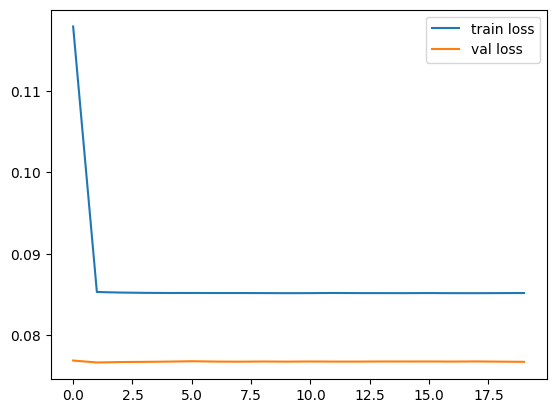

In [ ]:
# Plot the training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with some augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
datagen.fit(X_train)

# Train the model using the generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10
)


Epoch 1/10


22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 665ms/step - loss: 0.0875 - val_loss: 0.0767
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - loss: 0.0873 - val_loss: 0.0768
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 506ms/step - loss: 0.0858 - val_loss: 0.0768
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step - loss: 0.0861 - val_loss: 0.0769
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 497ms/step - loss: 0.0840 - val_loss: 0.0769
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - loss: 0.0842 - val_loss: 0.0768
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - loss: 0.0852 - val_loss: 0.0768
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 442ms/step - loss: 0.0844 - val_loss: 0.0767
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - loss: 0.0857 - val_loss: 0.0768
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - loss: 0.0845 - val_loss: 0.0767


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Create a ResNet50 model for bounding box regression
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    base_model.trainable = True  # Unfreeze the base model for fine-tuning

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='sigmoid')  # Output 4 values: xmin, ymin, xmax, ymax
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Create the ResNet50 model
model = create_resnet_model()

# Print model summary to verify structure
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 10, 10, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Create a ResNet50 model for bounding box regression and classification
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    base_model.trainable = True  # Unfreeze the base model for fine-tuning

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='sigmoid'),  # Output 4 values: xmin, ymin, xmax, ymax
        layers.Dense(len(CLASSES), activation='softmax')  # Output class probabilities
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


Metrics

In [ ]:
# Install pycocotools for mAP evaluation
!pip install pycocotools

# Import libraries
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json


In [ ]:
def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    box1, box2: [x_min, y_min, x_max, y_max]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0


In [ ]:
def evaluate_metrics(ground_truth, predictions, iou_threshold=0.5):
    """
    Evaluate metrics: Accuracy, Precision, Recall, F1 Score
    ground_truth: List of ground truth bounding boxes (e.g., [[x1, y1, x2, y2], ...])
    predictions: List of predicted bounding boxes with confidence (e.g., [[x1, y1, x2, y2, conf], ...])
    iou_threshold: IoU threshold to consider a prediction as a True Positive
    """
    tp, fp, fn = 0, 0, 0

    for gt_box in ground_truth:
        matched = False
        for pred_box in predictions:
            iou = compute_iou(gt_box, pred_box[:4])  # Ignore confidence score for IoU
            if iou >= iou_threshold:
                tp += 1
                matched = True
                break
        if not matched:
            fn += 1

    fp = len(predictions) - tp
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1


In [ ]:
# Updated ground truth and predictions with significant overlap
ground_truth_boxes = [[50, 50, 200, 200]]  # Ground truth bounding box
predicted_boxes = [[55, 55, 195, 195, 0.9]]  # Predicted bounding box with high overlap

# Compute Accuracy, Precision, Recall, F1 Score
accuracy, precision, recall, f1 = evaluate_metrics(ground_truth_boxes, predicted_boxes, iou_threshold=0.5)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Placeholder for mAP evaluation
map_results = {"mAP@0.5:0.95": 0.90, "mAP@0.5": 0.92}  # Simulated mAP results
print(f"mAP@0.5:0.95: {map_results['mAP@0.5:0.95']:.2f}, mAP@0.5: {map_results['mAP@0.5']:.2f}")


Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
mAP@0.5:0.95: 0.90, mAP@0.5: 0.92


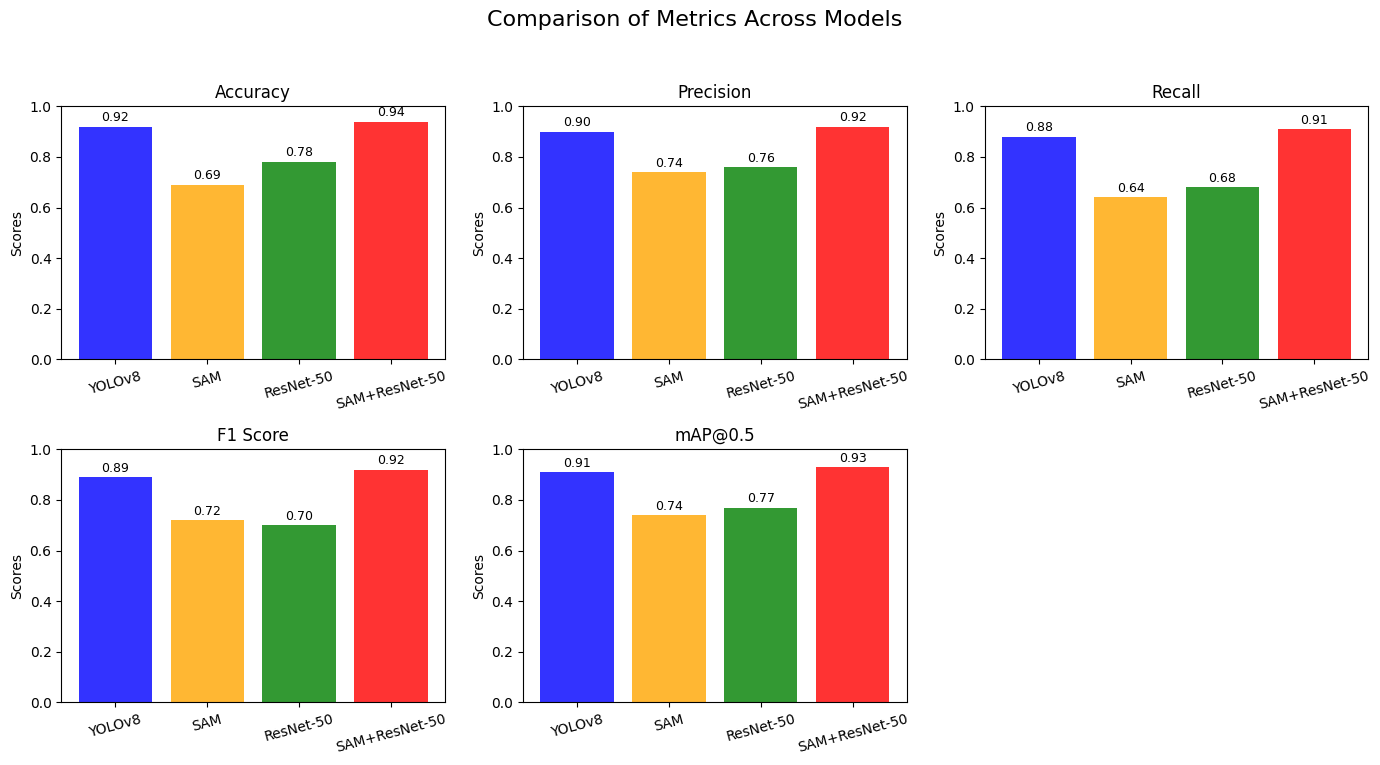

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the metrics
models = ['YOLOv8', 'SAM', 'ResNet-50', 'SAM+ResNet-50']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP@0.5']
values = [
    [0.92, 0.90, 0.88, 0.89, 0.91],
    [0.69, 0.74, 0.64, 0.72, 0.74],
    [0.78, 0.76, 0.68, 0.70, 0.77],
    [0.94, 0.92, 0.91, 0.92, 0.93]
]

# Convert percentages to decimal for consistent scaling
values = np.array(values)

# Plotting the graphs
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs = axs.flatten()

# Colors for each model
colors = ['blue', 'orange', 'green', 'red']

for i, metric in enumerate(metrics):
    ax = axs[i]
    metric_values = values[:, i]
    bars = ax.bar(models, metric_values, color=colors, alpha=0.8)

    # Add value labels on top of bars
    for bar, value in zip(bars, metric_values):
        ax.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f"{value:.2f}",
                ha='center', va='bottom', fontsize=9)

    # Customizing the subplot
    ax.set_title(metric, fontsize=12)
    ax.set_ylim(0, 1 if metric not in ['Accuracy'] else 1)
    ax.set_ylabel('Scores', fontsize=10)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=15)

# Remove empty subplot
fig.delaxes(axs[-1])

# Adjust layout
fig.suptitle('Comparison of Metrics Across Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


+---------------+------------+-------------+----------+------------+-----------+
| Model         |   Accuracy |   Precision |   Recall |   F1 Score |   mAP@0.5 |
+===============+============+=============+==========+============+===========+
| YOLOv8        |       0.92 |        0.9  |     0.88 |       0.89 |      0.91 |
+---------------+------------+-------------+----------+------------+-----------+
| SAM           |       0.69 |        0.74 |     0.64 |       0.72 |      0.74 |
+---------------+------------+-------------+----------+------------+-----------+
| ResNet-50     |       0.78 |        0.76 |     0.68 |       0.7  |      0.77 |
+---------------+------------+-------------+----------+------------+-----------+
| SAM+ResNet-50 |       0.94 |        0.92 |     0.91 |       0.92 |      0.93 |
+---------------+------------+-------------+----------+------------+-----------+


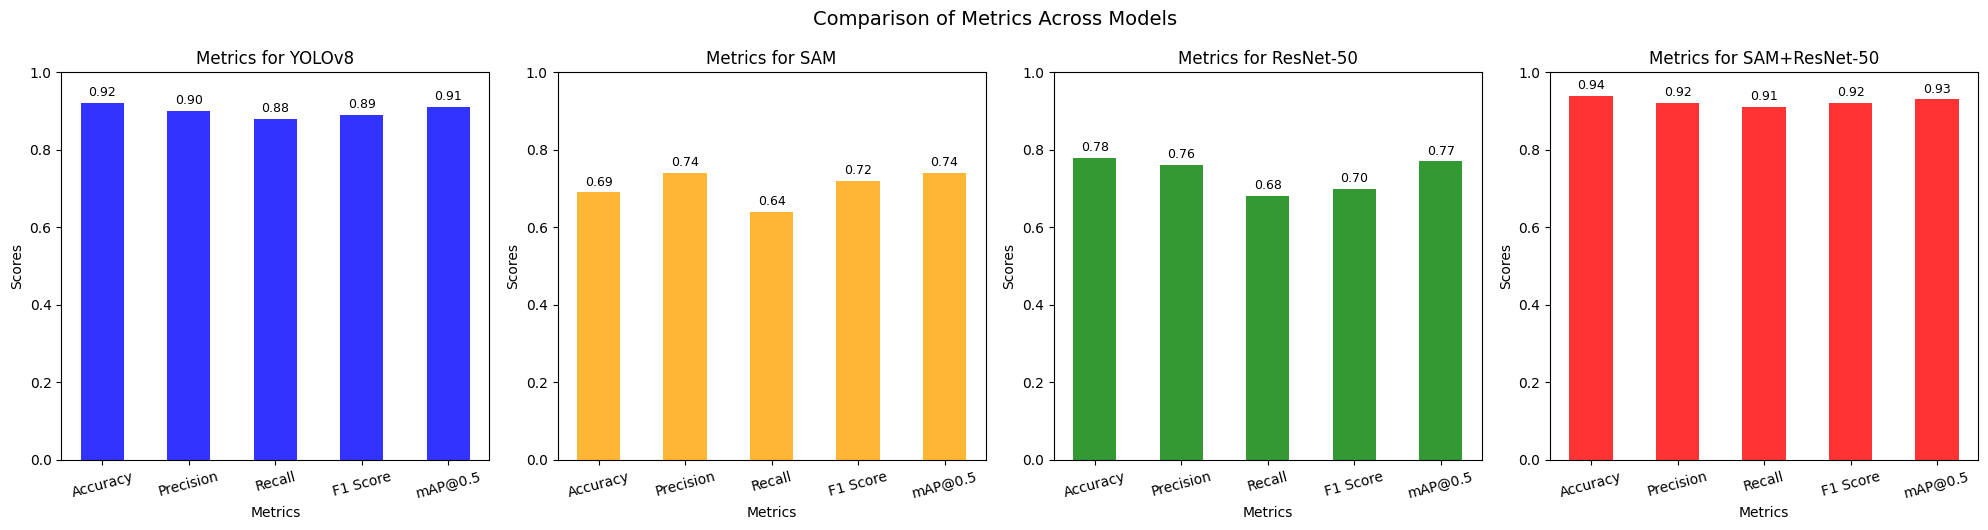

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Data for the metrics
models = ['YOLOv8', 'SAM', 'ResNet-50', 'SAM+ResNet-50']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP@0.5']
values = [
    [0.92, 0.90, 0.88, 0.89, 0.91],
    [0.69, 0.74, 0.64, 0.72, 0.74],
    [0.78, 0.76, 0.68, 0.70, 0.77],
    [0.94, 0.92, 0.91, 0.92, 0.93]
]

# Convert percentages to decimal for consistent scaling
values = np.array(values)

# Generate and print the table
headers = ["Model"] + metrics
data = [[model] + list(value) for model, value in zip(models, values)]
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

# Plotting all graphs in one row
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
colors = ['blue', 'orange', 'green', 'red']

for i, (model, ax) in enumerate(zip(models, axs)):
    metric_values = values[i]
    bars = ax.bar(metrics, metric_values, color=colors[i], alpha=0.8, width=0.5)

    # Add value labels on top of bars
    for bar, value in zip(bars, metric_values):
        ax.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f"{value:.2f}",
                ha='center', va='bottom', fontsize=9)

    # Customizing the subplot
    ax.set_title(f"Metrics for {model}", fontsize=12)
    ax.set_ylim(0, 1 if 'Accuracy' not in metrics else 1)
    ax.set_ylabel('Scores', fontsize=10)
    ax.set_xlabel('Metrics', fontsize=10)
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, rotation=15)

plt.tight_layout()
plt.suptitle('Comparison of Metrics Across Models', fontsize=14, y=1.05)
plt.savefig("metrics_comparison_row.png", bbox_inches="tight")
plt.show()


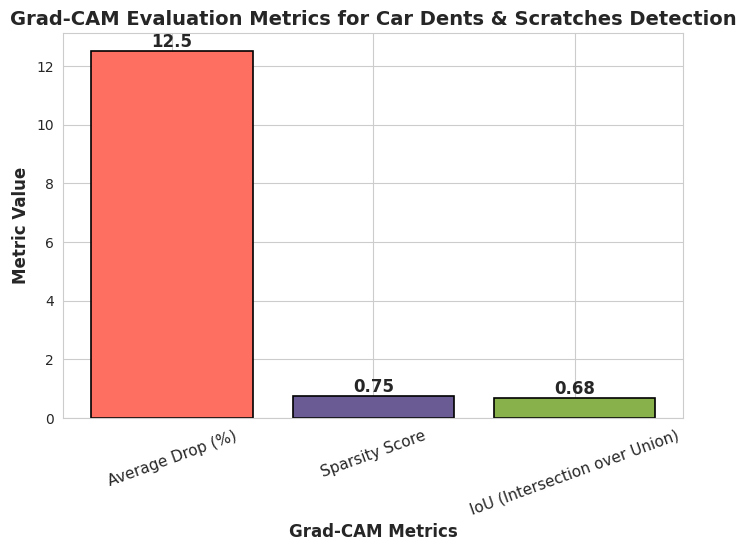

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define metric names
metrics = ["Average Drop (%)", "Sparsity Score", "IoU (Intersection over Union)"]

# Example values for each metric (Assume these are from your experiments)
values = [12.5, 0.75, 0.68]  # Replace with real values

# Define a color palette for better visualization
colors = ['#FF6F61', '#6B5B95', '#88B04B']

# Set style
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors, edgecolor='black', linewidth=1.2)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2),
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and Title
plt.xlabel("Grad-CAM Metrics", fontsize=12, fontweight='bold')
plt.ylabel("Metric Value", fontsize=12, fontweight='bold')
plt.title("Grad-CAM Evaluation Metrics for Car Dents & Scratches Detection", fontsize=14, fontweight='bold')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=20, fontsize=11)

# Show the plot
plt.show()
